In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler

zip_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)


ured_normalized = pd.read_csv('usa-real-estate-dataset-normalized.csv')
top_cities = ured_normalized['city'].value_counts().nlargest(200).index
ured_normalized['city'] = ured_normalized['city'].where(ured_normalized['city'].isin(top_cities), '__other__')
q_high = ured_normalized['price'].quantile(0.99)
ured_normalized = ured_normalized[ured_normalized['price'] < q_high]

ured_f2cat = pd.read_csv('usa-real-estate-dataset-normalized-zipcodes-f2cat.csv')
top_cities = ured_f2cat['city'].value_counts().nlargest(200).index
ured_f2cat['city'] = ured_f2cat['city'].where(ured_f2cat['city'].isin(top_cities), '__other__')
q_high = ured_f2cat['price'].quantile(0.99)
ured_f2cat = ured_f2cat[ured_f2cat['price'] < q_high]

ured_f2num = pd.read_csv('usa-real-estate-dataset-normalized-zipcodes-f2num.csv')
top_cities = ured_f2num['city'].value_counts().nlargest(200).index
ured_f2num['city'] = ured_f2num['city'].where(ured_f2num['city'].isin(top_cities), '__other__')
q_high = ured_f2num['price'].quantile(0.99)
ured_f2num = ured_f2num[ured_f2num['price'] < q_high]


ured_full_zipcode_geo = ured_normalized.copy()
ured_full_zipcode_geo = pd.get_dummies(ured_full_zipcode_geo, columns=['city', 'state'], drop_first=True)
ured_full_zipcode_geo[['zip_code']] = zip_encoder.fit_transform(ured_full_zipcode_geo[['zip_code']])
ured_full_zipcode_geo['zip_code'] = ured_full_zipcode_geo['zip_code'].astype('category')

ured_full_zipcode_nogeo = ured_normalized.drop(columns=['city', 'state'])
ured_full_zipcode_nogeo[['zip_code']] = zip_encoder.fit_transform(ured_full_zipcode_nogeo[['zip_code']])
ured_full_zipcode_nogeo['zip_code'] = ured_full_zipcode_nogeo['zip_code'].astype('category')

ured_zipcode_f2cat_geo = ured_f2cat.copy()
ured_zipcode_f2cat_geo = pd.get_dummies(ured_zipcode_f2cat_geo, columns=['city', 'state'], drop_first=True)
ured_zipcode_f2cat_geo[['zip_code']] = zip_encoder.fit_transform(ured_zipcode_f2cat_geo[['zip_code']])
ured_zipcode_f2cat_geo['zip_code'] = ured_zipcode_f2cat_geo['zip_code'].astype('category')

ured_zipcode_f2cat_nogeo = ured_f2cat.drop(columns=['city', 'state'])
ured_zipcode_f2cat_nogeo[['zip_code']] = zip_encoder.fit_transform(ured_zipcode_f2cat_nogeo[['zip_code']])
ured_zipcode_f2cat_nogeo['zip_code'] = ured_zipcode_f2cat_nogeo['zip_code'].astype('category')

ured_zipcode_f2num_geo = ured_f2num.copy()
ured_zipcode_f2num_geo = pd.get_dummies(ured_zipcode_f2num_geo, columns=['city', 'state'], drop_first=True)


ured_zipcode_f2num_nogeo = ured_f2num.drop(columns=['city', 'state'])

X1 = ured_full_zipcode_geo.drop(columns=['price'])
y1 = ured_full_zipcode_geo['price']
X2 = ured_full_zipcode_nogeo.drop(columns=['price'])
y2 = ured_full_zipcode_nogeo['price']
X3 = ured_zipcode_f2cat_geo.drop(columns=['price'])
y3 = ured_zipcode_f2cat_geo['price']
X4 = ured_zipcode_f2cat_nogeo.drop(columns=['price'])
y4 = ured_zipcode_f2cat_nogeo['price']
X5 = ured_zipcode_f2num_geo.drop(columns=['price'])
y5 = ured_zipcode_f2num_geo['price']
X6 = ured_zipcode_f2num_nogeo.drop(columns=['price'])
y6 = ured_zipcode_f2num_nogeo['price']

scaler = StandardScaler()

X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
X3 = scaler.fit_transform(X3)
X4 = scaler.fit_transform(X4)
X5 = scaler.fit_transform(X5)
X6 = scaler.fit_transform(X6)

In [3]:
def test_xgb_model(xgb_model_path, X, y):
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)
    xgb_model = XGBRegressor()
    xgb_model.load_model(xgb_model_path)
    y_pred = xgb_model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return mse, r2, mae

In [8]:
from tensorflow.keras.models import load_model
import numpy as np
def test_nn_model(model_path, X, y):
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)
    model = load_model(model_path)
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, r2, mae

In [14]:
import joblib
def test_decision_tree_model(model_path, X, y):
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)
    dt_model = joblib.load(model_path)
    y_pred = dt_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, r2, mae

| Model files (XGB) | Full zipcode | 2digit zipcode category | 2digit zipcode numerical  |
|---|---|---|---|
|Geographical data| xgb_model_zipcode_cat.json  | xgb_model_zipcode_f2cat.json  | xgb_model_zipcode_f2num.json  |
|No geographical data| xgb_model_200c_50s_zipcode_cat.json  | xgb_model_200c_50s_zipcode_f2cat.json  | xgb_model_200c_50s_zipcode_f2num.json  |

| Model files (NN) | Full zipcode | 2digit zipcode category | 2digit zipcode numerical  |
|---|---|---|---|
|Geographical data| nn_model_zipcode_cat.keras  | nn_model_zipcode_f2cat.keras  | nn_model_zipcode_f2num.keras  |
|No geographical data| nn_model_200c_50s_zipcode_cat.keras | nn_model_200c_50s_zipcode_f2cat.keras  | nn_model_200c_50s_zipcode_f2num.keras  |

| XGB/NN MAE | Full zipcode | 2digit zipcode category | 2digit zipcode numerical  |
|---|---|---|---|
|Geographical data| 142780.79 / 144519.16 | 148764.17 / 143654.35 | 148764.17 / 144369.42 |
|No geographical data| 143411.06 / 160915.05 | 148720.52 / 162946.5 | 148720.52 / 160783.66 |


In [ ]:
print(test_xgb_model('models/xgb_model_200c_50s_zipcode_cat.json',X1,y1))
print(test_xgb_model('models/xgb_model_zipcode_cat.json',X2,y2))
print(test_xgb_model('models/xgb_model_200c_50s_zipcode_f2cat.json',X3,y3))
print(test_xgb_model('models/xgb_model_zipcode_f2cat.json',X4,y4))
print(test_xgb_model('models/xgb_model_200c_50s_zipcode_f2num.json',X5,y5))
print(test_xgb_model('models/xgb_model_zipcode_f2num.json',X6,y6))


(62978534818.75423, 0.6834288629801465, 142780.7935079917)
(64312818328.47278, 0.676721884975751, 143411.06052450254)
(67714526787.635994, 0.6596226825597769, 148764.17032746598)
(68172950748.57583, 0.6573183451379947, 148720.5262110541)
(67714526787.635994, 0.6596226825597769, 148764.17032746598)
(68172950748.57583, 0.6573183451379947, 148720.5262110541)


In [9]:
print(test_nn_model('models/nn_model_200c_50s_zipcode_cat.keras',X1,y1))
print(test_nn_model('models/nn_model_zipcode_cat.keras',X2,y2))
print(test_nn_model('models/nn_model_200c_50s_zipcode_f2cat.keras',X3,y3))
print(test_nn_model('models/nn_model_zipcode_f2cat.keras',X4,y4))
print(test_nn_model('models/nn_model_200c_50s_zipcode_f2num.keras',X5,y5))
print(test_nn_model('models/nn_model_zipcode_f2num.keras',X6,y6))

10005/10005 ━━━━━━━━━━━━━━━━━━━━ 5s 522us/step
(77451394048.65352, 0.6076996055938289, 144519.16317193405)
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 5s 502us/step
(98872318793.11351, 0.49920010950318805, 160915.05914357232)
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 5s 533us/step
(75378074494.96968, 0.6182012122934999, 143654.35904050886)
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 6s 567us/step
(98696618499.72522, 0.5000900520954442, 162946.53035951994)
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 6s 571us/step
(78004057727.27849, 0.6049002992448387, 144369.42911028815)
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 5s 517us/step
(95005546824.25763, 0.5187857630229682, 160783.6604240034)


In [15]:
print(test_decision_tree_model('models/dt_model_200c_50s_zipcode_cat.joblib',X1,y1))
print(test_decision_tree_model('models/dt_model_zipcode_cat.joblib',X2,y2))
print(test_decision_tree_model('models/dt_model_200c_50s_zipcode_f2cat.joblib',X3,y3))
print(test_decision_tree_model('models/dt_model_zipcode_f2cat.joblib',X4,y4))
print(test_decision_tree_model('models/dt_model_200c_50s_zipcode_f2num.joblib',X5,y5))
print(test_decision_tree_model('models/dt_model_zipcode_f2num.joblib',X6,y6))

(74187979100.73314, 0.6242291850404679, 130845.87238326643)
(74337082919.39195, 0.6234739567119685, 130925.54934787356)
(93539918948.79816, 0.5262093401019585, 151195.4132545283)
(97043612905.21222, 0.5084627192972211, 153672.58161806522)
(93541548244.7268, 0.526201087526995, 151203.31587725724)
(97038142124.205, 0.5084904294446393, 153672.2616992163)


10005/10005 ━━━━━━━━━━━━━━━━━━━━ 5s 495us/step
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 4s 438us/step
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 5s 521us/step
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 5s 491us/step
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 6s 550us/step
10005/10005 ━━━━━━━━━━━━━━━━━━━━ 5s 513us/step


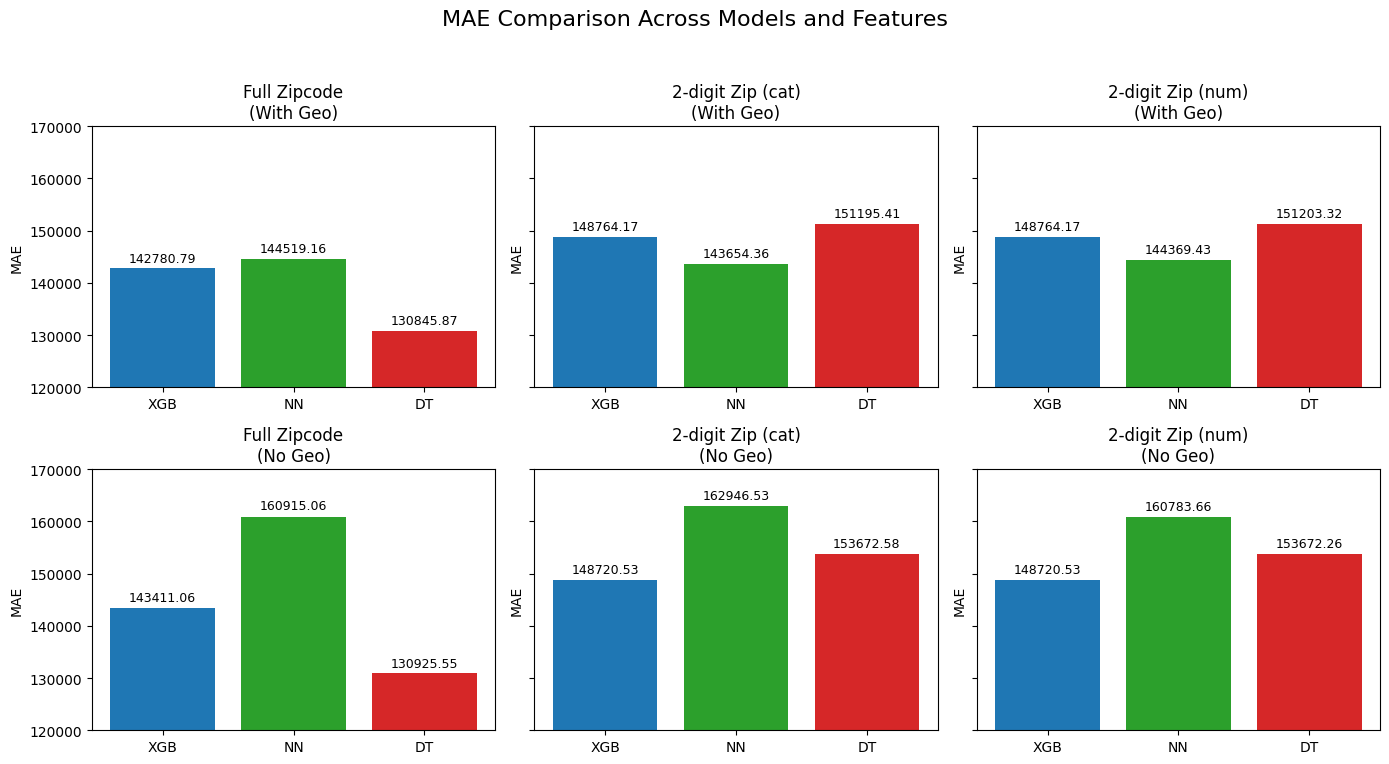

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Collect MAE results
xgb_maes = [
    test_xgb_model('models/xgb_model_200c_50s_zipcode_cat.json', X1, y1)[2],
    test_xgb_model('models/xgb_model_zipcode_cat.json', X2, y2)[2],
    test_xgb_model('models/xgb_model_200c_50s_zipcode_f2cat.json', X3, y3)[2],
    test_xgb_model('models/xgb_model_zipcode_f2cat.json', X4, y4)[2],
    test_xgb_model('models/xgb_model_200c_50s_zipcode_f2num.json', X5, y5)[2],
    test_xgb_model('models/xgb_model_zipcode_f2num.json', X6, y6)[2],
]

nn_maes = [
    test_nn_model('models/nn_model_200c_50s_zipcode_cat.keras', X1, y1)[2],
    test_nn_model('models/nn_model_zipcode_cat.keras', X2, y2)[2],
    test_nn_model('models/nn_model_200c_50s_zipcode_f2cat.keras', X3, y3)[2],
    test_nn_model('models/nn_model_zipcode_f2cat.keras', X4, y4)[2],
    test_nn_model('models/nn_model_200c_50s_zipcode_f2num.keras', X5, y5)[2],
    test_nn_model('models/nn_model_zipcode_f2num.keras', X6, y6)[2],
]

dt_maes = [
    test_decision_tree_model('models/dt_model_200c_50s_zipcode_cat.joblib', X1, y1)[2],
    test_decision_tree_model('models/dt_model_zipcode_cat.joblib', X2, y2)[2],
    test_decision_tree_model('models/dt_model_200c_50s_zipcode_f2cat.joblib', X3, y3)[2],
    test_decision_tree_model('models/dt_model_zipcode_f2cat.joblib', X4, y4)[2],
    test_decision_tree_model('models/dt_model_200c_50s_zipcode_f2num.joblib', X5, y5)[2],
    test_decision_tree_model('models/dt_model_zipcode_f2num.joblib', X6, y6)[2],
]

# Format: [ [X1, X3, X5], [X2, X4, X6] ]
mae_matrix = [
    [(xgb_maes[0], nn_maes[0], dt_maes[0]),
     (xgb_maes[2], nn_maes[2], dt_maes[2]),
     (xgb_maes[4], nn_maes[4], dt_maes[4])],
    [(xgb_maes[1], nn_maes[1], dt_maes[1]),
     (xgb_maes[3], nn_maes[3], dt_maes[3]),
     (xgb_maes[5], nn_maes[5], dt_maes[5])]
]

model_names = ['XGB', 'NN', 'DT']
column_labels = ['Full Zipcode', '2-digit Zip (cat)', '2-digit Zip (num)']
row_labels = ['With Geo', 'No Geo']

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharey=True)
ymax = max(max(row) for row in sum(mae_matrix, [])) * 1.1
for i in range(2):  # rows
    for j in range(3):  # columns
        maes = mae_matrix[i][j]
        ax = axes[i, j]
        ax.bar(model_names, maes, color=['#1f77b4', '#2ca02c', '#d62728'])
        ax.set_title(f'{column_labels[j]}\n({row_labels[i]})')
        ax.set_ylabel('MAE')
        ax.set_ylim(120000, 170000)
        for k, v in enumerate(maes):
            ax.text(k, v + 0.005 * v, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

fig.suptitle('MAE Comparison Across Models and Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()